In [1]:
import psutil, os, time, threading
def memwatch():
    while True:
        print(f"RAM {psutil.virtual_memory().percent:5.1f}% ", end="\r")
        time.sleep(5)
threading.Thread(target=memwatch, daemon=True).start()


In [2]:
!pip install rasterio joblib cupy-cuda12x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 88.5 MB/s eta 0:00:00:00:0100:01


In [3]:
import numpy as np
import rasterio
import os
from concurrent.futures import ThreadPoolExecutor

In [4]:
# Dataset path (adjust this to your drive folder)
dataset_path = '/kaggle/input/dataset/dataset'

In [5]:
def load_bands(scene):
    suf = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
    stacks = []
    for s in suf:
        f = next(f for f in os.listdir(scene) if s in f)
        with rasterio.open(os.path.join(scene,f)) as src:
            b = src.read(1).astype(np.float32)
            b[b == src.nodata] = np.nan   # just drop nodata / border
            b /= 10000.0
            stacks.append(b)
    return np.stack(stacks, -1)


In [6]:
def flatten_scene(scene_path):
    # reads the six SR bands, converts nodata (‑9999) → NaN, scales to [0‑1]
    img = load_bands(scene_path)            # shape: (rows, cols, 6)

    # reshape to (n_pixels, 6) and keep rows that have *no* NaNs
    flat   = img.reshape(-1, 6)
    valid  = ~np.isnan(flat).any(axis=1)
    return flat[valid]                      # array of good spectra


In [7]:


pip install numpy tqdm


Note: you may need to restart the kernel to use updated packages.


In [8]:
from tqdm import trange


In [9]:
import cupy as cp
from cupy.cuda import cub

# 2.1 – the CUDA C classify‐and‐flag kernel
classify_src = r'''
extern "C" __global__
void classify_and_flag(
    const float* pixels, const float* centers,
    const int* old_labels, int* new_labels,
    unsigned int* flags,
    int N, int D, int K
) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    if (idx >= N) return;
    const float* pix = pixels + idx * D;
    float best_d2 = 1e30f;
    int best_k = 0;
    for(int c=0; c<K; ++c) {
        const float* cent = centers + c * D;
        float d2 = 0;
        #pragma unroll
        for(int d=0; d<D; ++d) {
            float diff = pix[d] - cent[d];
            d2 += diff * diff;
        }
        if (d2 < best_d2) {
            best_d2 = d2; best_k = c;
        }
    }
    new_labels[idx] = best_k;
    flags[idx]      = (old_labels[idx] != best_k);
}
'''
# compile it once
classify_kernel = cp.RawKernel(classify_src, 'classify_and_flag')

# 2.2 – one-hot ElementwiseKernel
onehot_kernel = cp.ElementwiseKernel(
    'int32 label', 'raw uint32 out',
    'out[i * _ind.size(1) + label] = 1;',
    'onehot'
)

In [10]:
def iikmc_gpu_on_flat(X, k=8, max_iter=100, tol=1e-4):
    # X: NumPy array (N, D), already flattened & downsampled
    N, D = X.shape

    # Copy to GPU
    d_pixels     = cp.array(X)                        # (N, D)
    d_old_labels = cp.zeros(N, cp.int32)             # (N,)
    d_new_labels = cp.zeros_like(d_old_labels)       # (N,)
    d_flags      = cp.zeros(N, cp.uint32)            # (N,)

    # Initialize centers on host and copy
    mins = X.min(axis=0); maxs = X.max(axis=0)
    host_centers = np.stack([
        mins + (i + 0.5)*(maxs - mins)/k
        for i in range(k)
    ]).astype(np.float32)                            # (k, D)
    d_centers = cp.array(host_centers)               # (k, D)

    # Pre-compile kernels (as before)
    classify_kernel = cp.RawKernel(classify_src, 'classify_and_flag')
    onehot_kernel   = cp.ElementwiseKernel(
        'int32 label', 'raw uint32 out',
        'out[i * _ind.size(1) + label] = 1;',
        'onehot'
    )

    for it in range(max_iter):
        # 1) classify + flag kernel launch
        threads = 256
        blocks  = (N + threads - 1) // threads
        classify_kernel(
            (blocks,), (threads,),
            (d_pixels.ravel(), d_centers.ravel(),
             d_old_labels, d_new_labels, d_flags,
             N, D, k)
        )

        # 2) reduce flags → n_changed
        #    (pure CuPy reduction on device)
        n_changed = int(d_flags.sum())

        # 3) one-hot matrix & per-class counts
        onehot = cp.zeros((N, k), cp.uint32)
        idx = cp.arange(N, dtype=cp.int32)
        onehot[idx, d_new_labels] = 1
        counts = onehot.sum(axis=0)

        # 4) per-class feature sums
        sums = cp.tensordot(onehot.T, d_pixels, axes=([1], [0]))  # (k, D)

        # 5) update centers & check convergence
        new_centers = (sums / counts[:, None]).astype(cp.float32)
        shift = float(cp.linalg.norm(d_centers - new_centers) / k)
        d_centers[:] = new_centers

        print(f"Iter {it+1}: changed {n_changed}/{N} → shift {shift:.2e}")
        if n_changed / N < tol:
            print(f"Converged at iter {it+1}")
            break

        # swap labels for next iteration
        d_old_labels, d_new_labels = d_new_labels, d_old_labels

    # bring centers & labels back to CPU
    return cp.asnumpy(d_centers), cp.asnumpy(d_old_labels)


In [28]:
def downsample_scenes(scenes, sample_frac=0.2, random_seed=42):
    rng = np.random.RandomState(random_seed)
    out_data = []
    out_masks = []

    for s in scenes:
        mask = rng.rand(s.shape[0]) < sample_frac
        if not mask.any():
            mask[rng.randint(s.shape[0])] = True
        out_data.append(s[mask])
        out_masks.append(mask)
    
    return out_data, out_masks


In [29]:
from pathlib import Path
dataset_dir = Path("/kaggle/input/dataset/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())
flat_scenes = [flatten_scene(p) for p in scene_paths]

In [30]:
flat_scenes_ds, downsample_masks = downsample_scenes(flat_scenes, sample_frac=0.2,random_seed=123)
print("Original total pixels:", sum(s.shape[0] for s in flat_scenes))
print("Down-sampled total pixels:", sum(s.shape[0] for s in flat_scenes_ds))

Original total pixels: 203197885
Down-sampled total pixels: 40651997


In [24]:
import time
start = time.time()
X_sampled = np.vstack(flat_scenes_ds).astype(np.float32)
centres, labels_dict = iikmc_gpu_on_flat(
        X_sampled,
        k=8,
        max_iter=60,
        tol=1e-4)     # tweak if it stops too soon / late
end = time.time()
print(f"GPU IIkMC finished in {end - start:.2f} seconds")

Iter 1: changed 39112607/40651997 → shift 6.97e-01
Iter 2: changed 3835445/40651997 → shift 4.34e-01
Iter 3: changed 3000603/40651997 → shift 3.52e-01
Iter 4: changed 2078599/40651997 → shift 2.46e-01
Iter 5: changed 1715718/40651997 → shift 1.38e-01
Iter 6: changed 1621750/40651997 → shift 1.07e-01
Iter 7: changed 1624632/40651997 → shift 6.95e-02
Iter 8: changed 1595637/40651997 → shift 4.11e-02
Iter 9: changed 1279161/40651997 → shift 2.49e-02
Iter 10: changed 1326822/40651997 → shift 1.68e-02
Iter 11: changed 1446261/40651997 → shift 1.16e-02
Iter 12: changed 1445016/40651997 → shift 9.13e-03
Iter 13: changed 1364697/40651997 → shift 6.83e-03
Iter 14: changed 1236603/40651997 → shift 5.54e-03
Iter 15: changed 1093286/40651997 → shift 4.62e-03
Iter 16: changed 952778/40651997 → shift 3.90e-03
Iter 17: changed 824676/40651997 → shift 3.31e-03
Iter 18: changed 709756/40651997 → shift 2.82e-03
Iter 19: changed 607624/40651997 → shift 2.51e-03
Iter 20: changed 519056/40651997 → shift 2.

/tmp/ipykernel_35/1742113187.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


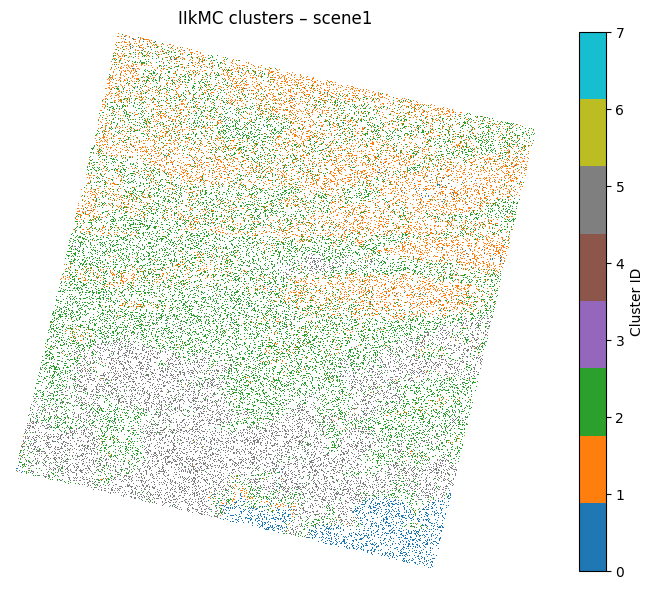

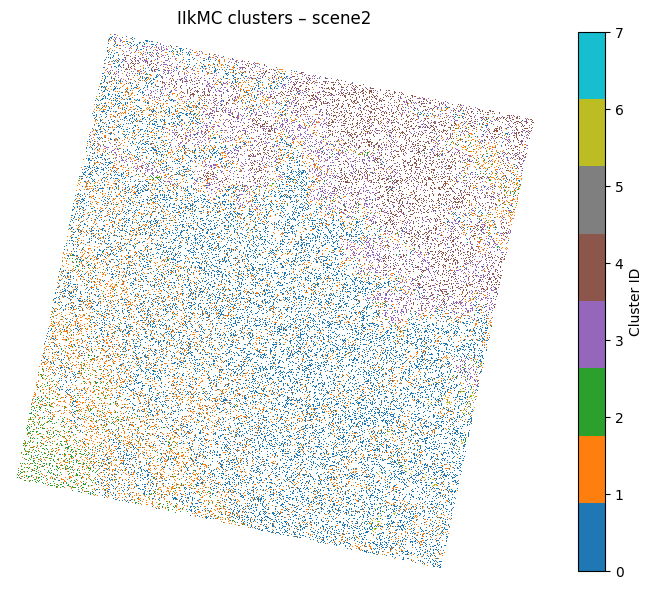

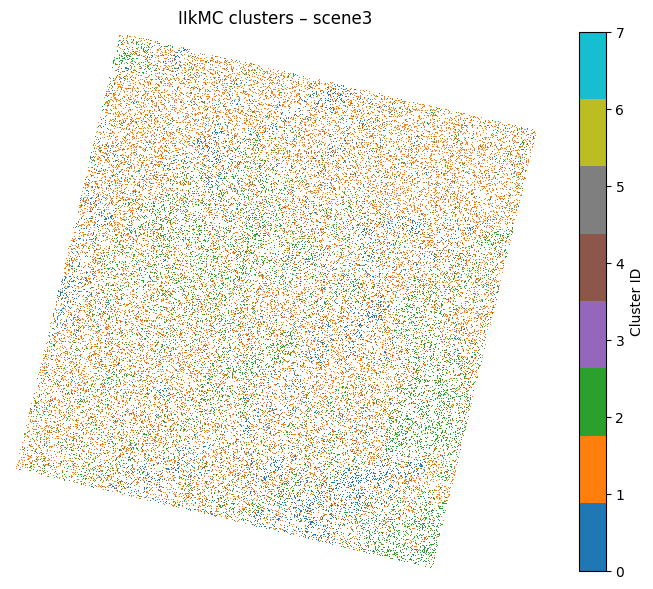

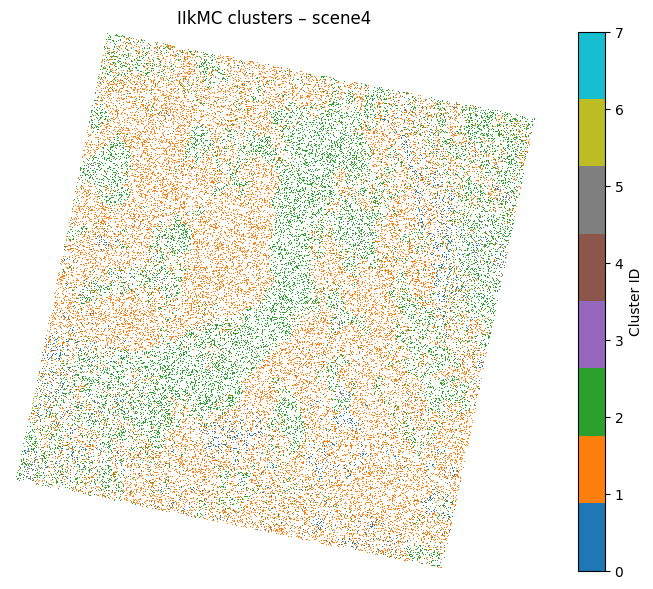

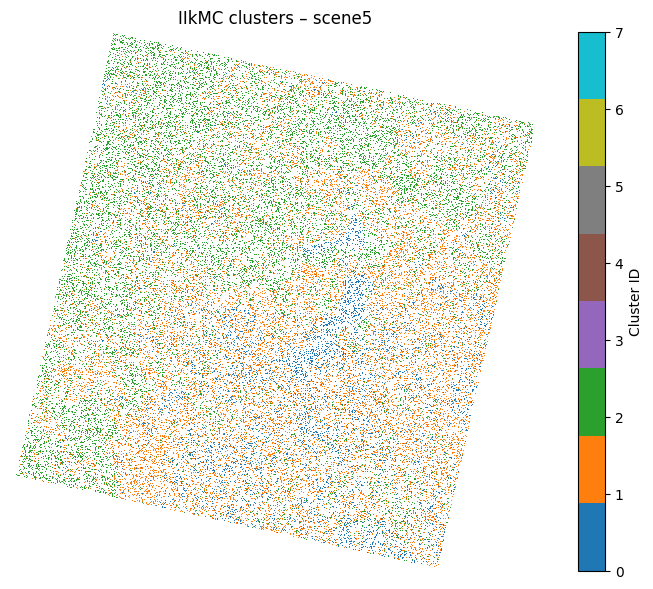

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def map_labels_back_downsampled(scene_path, downsample_mask, labels_1d):
    img = load_bands(scene_path)  # (rows, cols, 6)
    rows, cols = img.shape[:2]
    flat = img.reshape(-1, 6)
    valid = ~np.isnan(flat).any(axis=1)

    if downsample_mask.sum() != len(labels_1d):
        raise ValueError(f"label mismatch: {downsample_mask.sum()} vs {len(labels_1d)}")

    out = np.full(rows * cols, np.nan, np.float32)
    valid_idx = np.where(valid)[0]
    downsampled_idx = valid_idx[downsample_mask]
    out[downsampled_idx] = labels_1d.astype(np.float32)
    return out.reshape(rows, cols)

# ----------- iterate and slice labels for each downsampled scene -----------
for sc_path, mask in zip(scene_paths, downsample_masks):
    n = mask.sum()
    scene_labels = labels_dict[:n]
    labels_dict = labels_dict[n:]

    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])
    except Exception as e:
        print(f"Skipping {sc_path.name}: {e}")